# Project 1 - Microlensing 1
# Brandon Shane, Ina Park, Toshan Vysyraju, Arya Lakshmanan

In [9]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import emcee
import corner

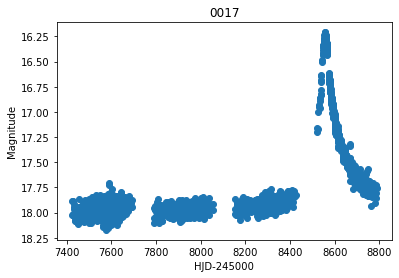

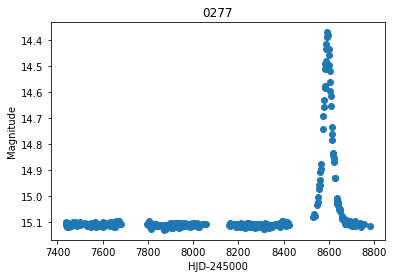

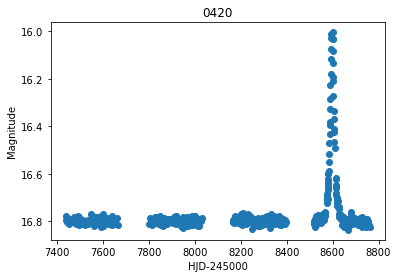

In [10]:
# _locs = ['OGLE-2019-BLG-/blg-0017/',]
Data = {}
names = ['0017','0277','0420']

for name in names:
    d = np.loadtxt('OGLE-2019-BLG-'+name+'/blg-'+name+'/phot.dat', dtype=float)
    x = d[:,0] - 245e4
    y = d[:,1]
    
    plt.scatter(x,y)
    plt.gca().invert_yaxis()
    plt.title(name)
    plt.xlabel('HJD-245000')
    plt.ylabel('Magnitude')
    plt.show()

    
    Data[name] = d
    


In [11]:
def xi(param):
    'X^2 to mininize to find parameters'
    #m_bl being the baseline magnitude
    umin,tE, m_bl, t_0 = param 
    
    u = np.sqrt(umin**2 + ((x-t_0)/tE)**2)
    A = u**2 + 2
    A /= (u*np.sqrt((u**2)+4))
    #m_mod refers to m observed as predicted by our model 
    m_mod = m_bl - 2.5*np.log10(A)
    
    if (tE < 1 or umin < 8e-4):
        return 1e8
    tot = 0
    for i in range(len(y)):
        tot += ((y[i] - m_mod[i])**2)/s[i]**2 
    return tot

In [12]:
# Creating lists of parameters to call later in emcee
uminlist = []
tElist = []
m_bllist = []
t_0list = []

Optimization terminated successfully.
         Current function value: 64760.065746
         Iterations: 423
         Function evaluations: 718


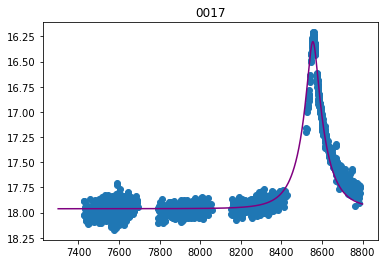

Optimization terminated successfully.
         Current function value: 1894.523544
         Iterations: 413
         Function evaluations: 713


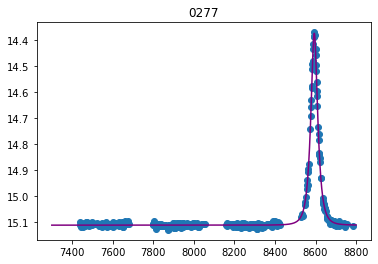

Optimization terminated successfully.
         Current function value: 1172.420696
         Iterations: 444
         Function evaluations: 753


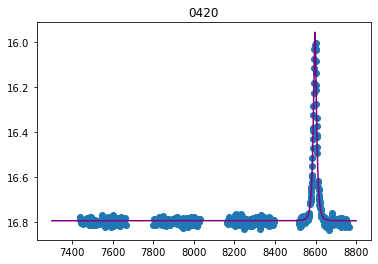

In [13]:
for name in Data.keys():
    d = Data[name]
    x = d[:,0] - 245e4
    y = d[:,1]
    s = d[:,2]
    
    
    # Might want to plot error barrs in scatterplot
    plt.scatter(x,y)
    # f_src_guess = np.nanmean(y[(x>7400) & (x<8400)])
    #plt.axhline(y=f_src_guess)
    
    f_src_guess = np.nanmean(y[(x>7400) & (x<8000)])
    
    opt = optimize.fmin(xi,[0.1,1000,f_src_guess, x[y==np.max(y)]])
    opt = np.array(opt)

    xlist = np.linspace(7300, 8800, 1000)
    #umin,tE, m_bl, t_0 = [0.036, 421, 17.99, 8600]
    umin,tE, m_bl, t_0 = opt
    uminlist.append(umin)
    tElist.append(tE)
    m_bllist.append(m_bl)
    t_0list.append(t_0)

    u=[]
    A=[]
    m_mod=[]
    for i in range(len(xlist)):
        u.append(np.sqrt(umin**2 + ((xlist[i]-t_0)/tE)**2))
        A.append((u[i]**2 + 2)/(u[i]*np.sqrt((u[i]**2)+4)))
        m_mod.append(m_bl - 2.5*np.log10(A[i]))
    plt.gca().invert_yaxis()

    # A 

    plt.plot(xlist,m_mod,color='purple')
    plt.title(name)
    plt.show()

In [14]:
def lnprob(param,dat):
    x,y,sig = dat
    return -0.5*xi(param)

burn-in run
main run


<ipython-input-15-24636a3f2c9f>:54: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


burn-in run
main run


<ipython-input-15-24636a3f2c9f>:54: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


burn-in run
main run


<ipython-input-15-24636a3f2c9f>:54: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


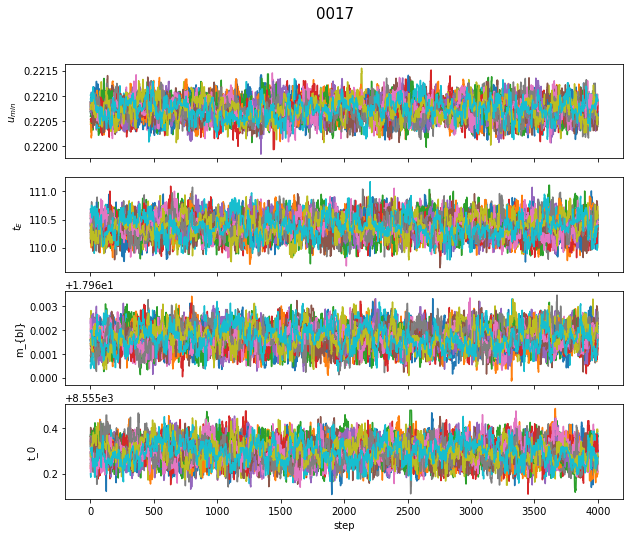

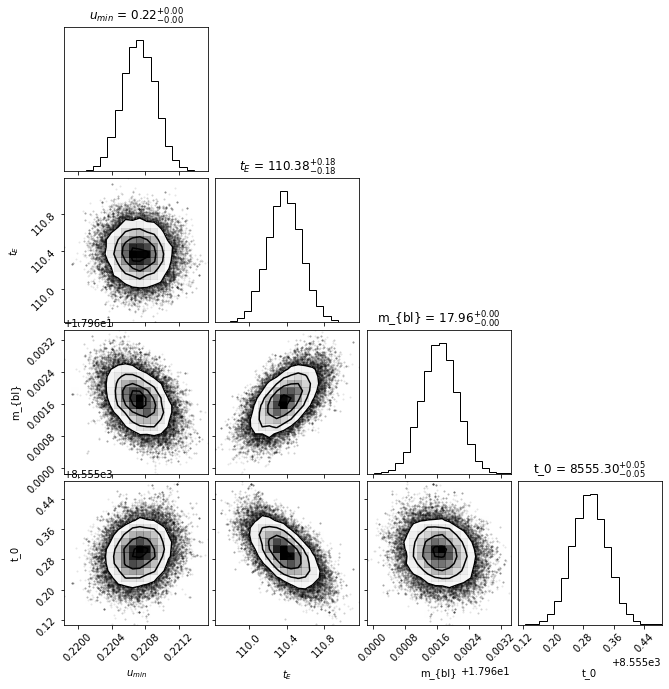

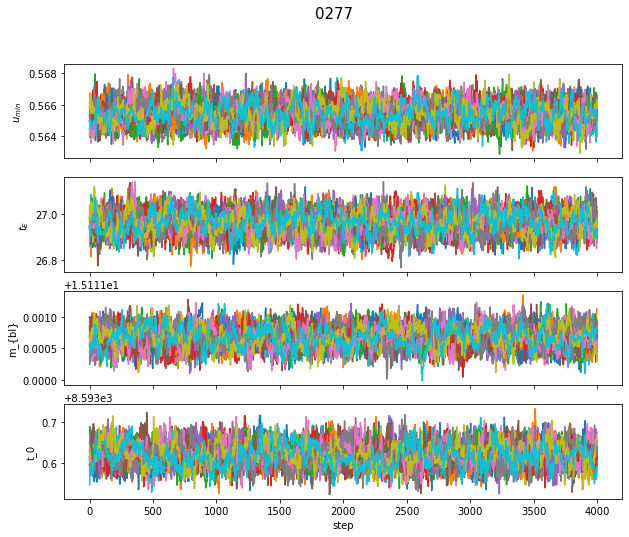

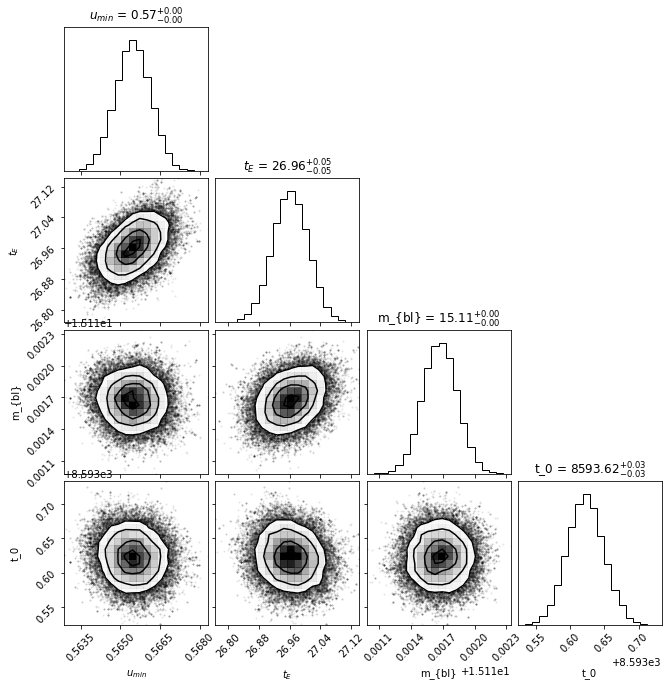

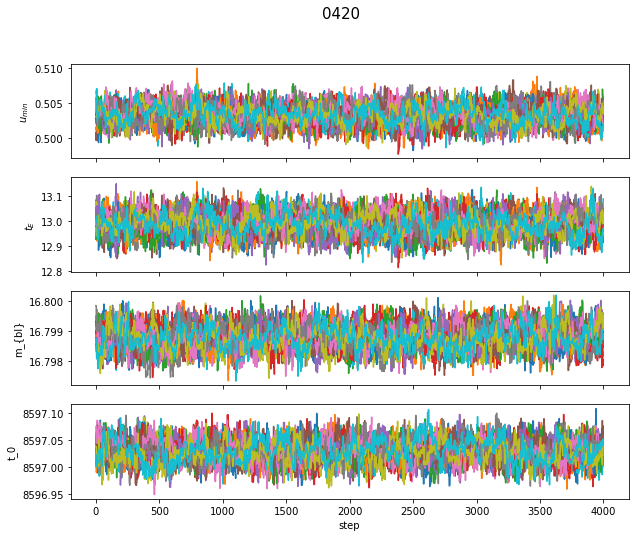

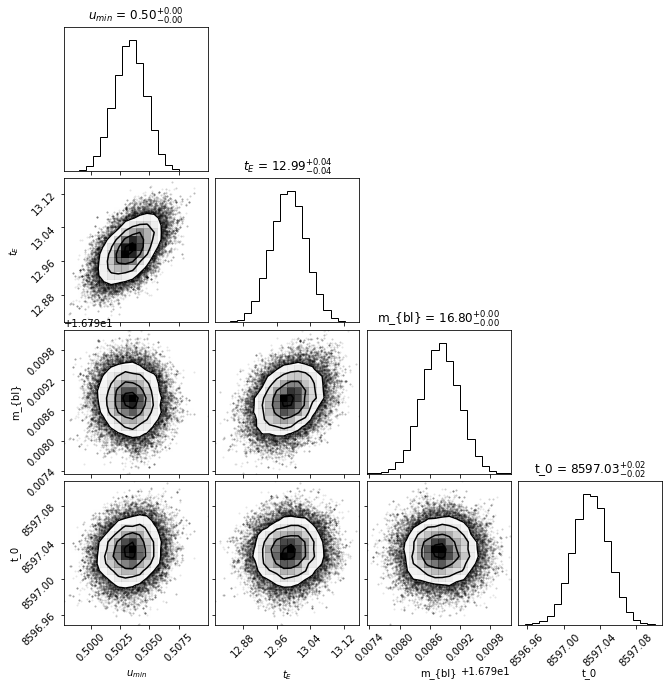

In [15]:
# temp = {}

for name in Data.keys():
    data = Data[name]
    x = data[:,0] - 245e4
    y = data[:,1]
    s = data[:,2]
    
    x=np.array(x,dtype=float)
    y=np.array(y,dtype=float)
    s=np.array(s,dtype=float)
    data = x,y,s
    
    
    ndim = 4
    nwalk = 20
    nburn = 400
    nmain = 4000
    
    f_src_guess = np.nanmean(y[(x>7400) & (x<8000)])
    params = [uminlist[names.index(name)],tElist[names.index(name)],m_bllist[names.index(name)], t_0list[names.index(name)]]
    # list of parameter names, for corner()
    #umin,tE, m_bl, t_0 = [0.036, 421, 17.99, 8600]
    plab = ['$u_{min}$','$t_E$','m_{bl}','t_0']

    # set up walkers by perturbing p0
    p0 = np.array(params)
    pstart = np.array([p0 + 1.0e-4*np.random.normal(size=ndim) for i in range(nwalk)])
    pstart = np.array(pstart,dtype=float)

    # set up the sampler
    sampler = emcee.EnsembleSampler(nwalk,ndim,lnprob,args=(data,))

    # burn-in run
    print('burn-in run')
    pos,prob,state = sampler.run_mcmc(pstart,nburn)

    # main run
    print('main run')
    sampler.reset()
    res = sampler.run_mcmc(pos,nmain)

    # process
    samples = sampler.get_chain(flat=True)
    #temp[Name] = samples
    # plot the chains as a way to check for convergence
    f,ax = plt.subplots(ndim,1,figsize=(10,8),sharex=True)
    for idim in range(ndim):
        for iwalk in range(nwalk):
            ax[idim].plot(sampler.chain[iwalk,:,idim])
        ax[idim].set_ylabel(plab[idim])
    f.suptitle(name,fontsize = 15)
    ax[-1].set_xlabel('step')
    f.show()

    # corner plot
    f = corner.corner(samples,show_titles=True,labels=plab)
    #f.show()
    # f.savefig('sample_corner.pdf',bbox_inches='tight')